#### Randhal S. Ramirez O. 

### Part 1. For the theoretical Loss function

### $Total Loss = MSE_u + MSE_f$

Where

### $MSE_u = \frac{1}{N_u} \sum_{i=0}^{N_u}\left( |y_1|^2+|y_2-1|^2+|y_3-2|^2 \right)$

### $MSE_f = \frac{1}{N_f} \sum_{i=0}^{N_f}\left( |y_{1,x}-(\sin(x)+x)|^2+|y_{2,x}-(\cos(x)+x)|^2+|y_{3,x}-(x^2+y_1-y_2)|^2 \right)$

Item 1 solved.


Compiling model...
Building feed-forward neural network...
'build' took 0.023678 s

'compile' took 0.149018 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.00e+00, 5.60e-01, 2.77e-02, 0.00e+00, 1.00e+00, 4.00e+00]    [1.03e+00, 5.74e-01, 2.77e-02, 0.00e+00, 1.00e+00, 4.00e+00]    []  
1000      [1.60e-03, 3.87e-04, 7.52e-04, 9.34e-07, 8.54e-08, 5.18e-09]    [1.37e-03, 3.45e-04, 6.88e-04, 9.34e-07, 8.54e-08, 5.18e-09]    []  
2000      [3.95e-04, 1.64e-04, 2.56e-04, 1.13e-07, 1.77e-08, 2.58e-09]    [3.40e-04, 1.38e-04, 2.34e-04, 1.13e-07, 1.77e-08, 2.58e-09]    []  
3000      [1.69e-05, 6.81e-05, 6.12e-05, 2.41e-07, 1.30e-09, 2.04e-08]    [1.26e-05, 5.72e-05, 5.54e-05, 2.41e-07, 1.30e-09, 2.04e-08]    []  
4000      [1.36e-05, 8.65e-06, 2.93e-05, 1.94e-06, 7.70e-08, 2.27e-07]    [1.24e-05, 8.01e-06, 2.83e-05, 1.94e-06, 7.70e-08, 2.27e-07]    []  
5000 

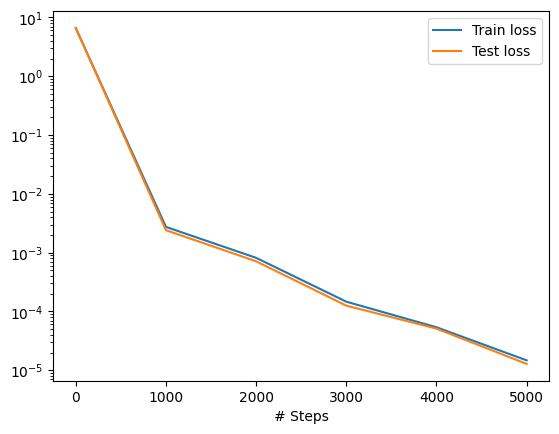

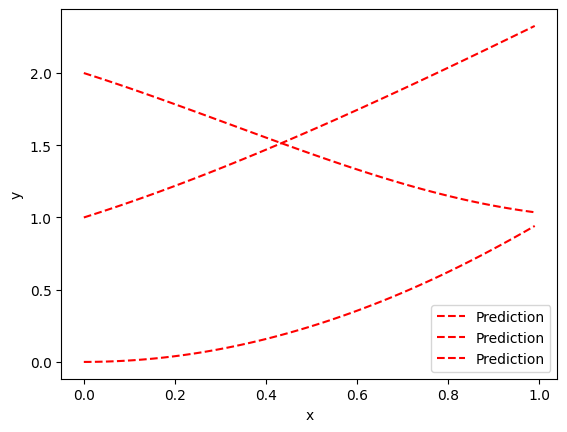

In [7]:
# This script solves the system of ODEs using a Physics-Informed Neural Network (PINN) 
import deepxde as dde
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Define the ODE system
def ode_system(x, y):
    y1, y2 = y[:, 0:1], y[:, 1:2]
    
    dy1_dx = dde.grad.jacobian(y, x, i=0)
    dy2_dx = dde.grad.jacobian(y, x, i=1)
    dy3_dx = dde.grad.jacobian(y, x, i=2)
    
    return [dy1_dx - (tf.sin(x) + x),
            dy2_dx - (tf.cos(x) + x),
            dy3_dx - (x**2 + y1 - y2)]

# Define geometry and time domain
geom = dde.geometry.Interval(0, 1)

# Define initial conditions (point-wise)
def boundary(x, on_boundary):
    return on_boundary and np.isclose(x[0], 0)

bc1 = dde.icbc.DirichletBC(geom, lambda x: 0 * x[:, 0:1], boundary, component=0)
bc2 = dde.icbc.DirichletBC(geom, lambda x: 1 + 0 * x[:, 0:1], boundary, component=1)
bc3 = dde.icbc.DirichletBC(geom, lambda x: 2 + 0 * x[:, 0:1], boundary, component=2)

# Define PDE problem
data = dde.data.PDE(
    geom,
    ode_system,
    [bc1, bc2, bc3],
    num_domain=100,
    num_boundary=3,
    num_test=100,
)

# Build the neural network
layer_size = [1] + [32] * 3 + [3]
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN(layer_size, activation, initializer)

# Define model
model = dde.Model(data, net)

# Compile and train
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=5000)
# Plot training loss
dde.saveplot(losshistory, train_state, issave=False, isplot=True)


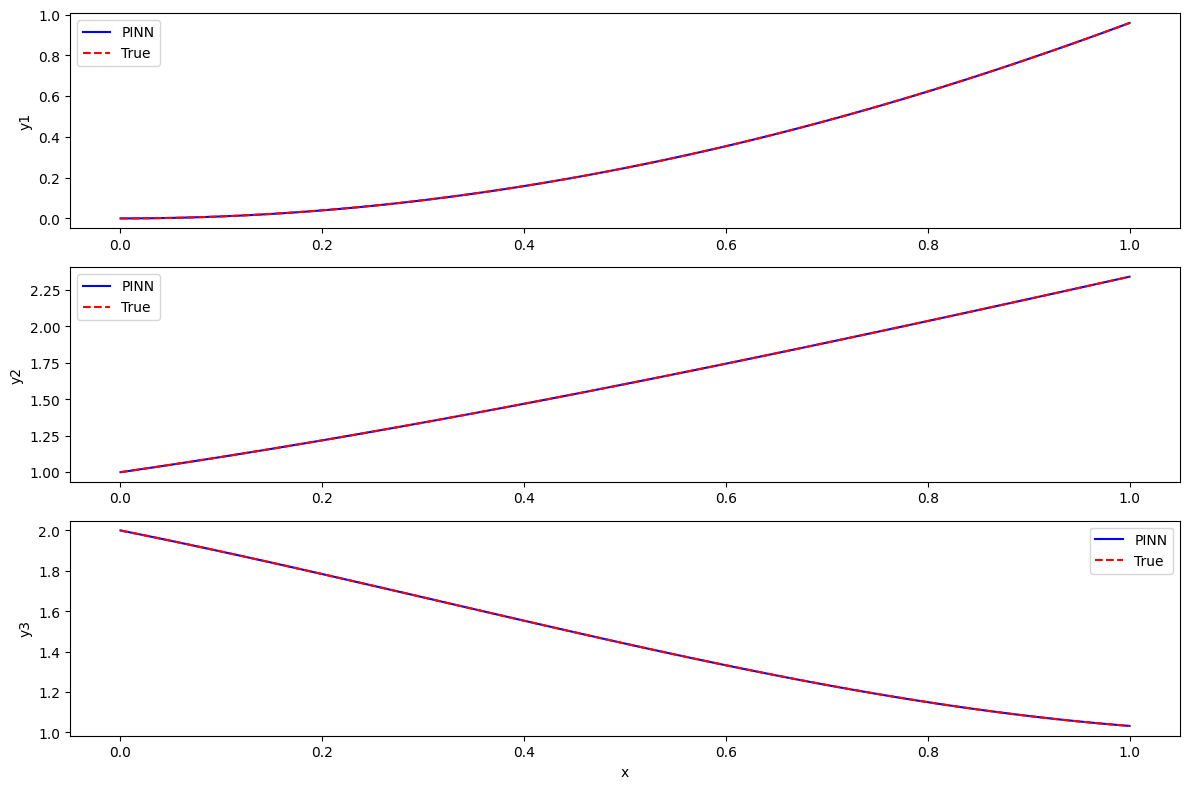

In [8]:
# Solve item 3. 
# Define true solutions for comparison
def y1_true(x):
    return -np.cos(x) + 0.5 * x**2 + 1

def y2_true(x):
    return np.sin(x) + 0.5 * x**2 + 1

def y3_true(x):
    return (1/3) * x**3 - np.sin(x) + np.cos(x) + 1

# Plot comparison
x = np.linspace(0, 1, 100).reshape(-1, 1)
y_pred = model.predict(x)
y1_pred = y_pred[:, 0]
y2_pred = y_pred[:, 1]
y3_pred = y_pred[:, 2]

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(x, y1_pred, 'b-', label='PINN')
plt.plot(x, y1_true(x), 'r--', label='True')
plt.ylabel('y1')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(x, y2_pred, 'b-', label='PINN')
plt.plot(x, y2_true(x), 'r--', label='True')
plt.ylabel('y2')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(x, y3_pred, 'b-', label='PINN')
plt.plot(x, y3_true(x), 'r--', label='True')
plt.ylabel('y3')
plt.legend()

plt.xlabel('x')
plt.tight_layout()
plt.show()